### Análise explorátoria dos dados 


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [133]:
df = pd.read_csv(r"\data\df_transactions_clients_offers.csv")
df

,evento,id_cliente,time,quantia,id_oferta,cupom,idade,genero,limite_cartao,data,valor_minimo_compra,duracao,tipo_oferta,valor_desconto,'email','mobile','social','web'
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,2017-05-09,5.0,7.0,bogo,5.0,yes,yes,NaN,yes
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,20.0,10.0,discount,5.0,yes,NaN,NaN,yes
2,offer received,e2127556f4f64592b11af22de27a7932,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2018-04-26,10.0,7.0,discount,2.0,yes,yes,NaN,yes
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.00,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,NaN,10.0,10.0,discount,2.0,yes,yes,yes,yes
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.00,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,NaN,10.0,5.0,bogo,10.0,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59,NaN,NaN,66.0,M,47000.0,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53,NaN,NaN,52.0,M,62000.0,2018-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,transaction,a00058cf10334a308c68e7631c529907,29.75,3.61,NaN,NaN,63.0,F,52000.0,2013-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,29.75,3.53,NaN,NaN,57.0,M,40000.0,2016-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
# Analisando a quantidade de ofertas visualizadas, completadas, recebidas e transações, 
# e porcentagem de visualização e completamento de ofertas
ofertas_visualizadas = df[df['evento'] == 'offer viewed'].shape[0]
print("ofertas_visualizadas:", ofertas_visualizadas)

ofertas_completadas = df[df['evento'] == 'offer completed'].shape[0]
print("ofertas_completadas:", ofertas_completadas)

ofertas_recebidas = df[df['evento'] == 'offer received'].shape[0]
print("ofertas_recebidas:", ofertas_recebidas)

transacoes = df[df['evento'] == 'transaction'].shape[0]
print("transacoes:", transacoes)

taxa_visualizacao = round((ofertas_visualizadas / ofertas_recebidas),4) * 100
print("taxa_visualizacao:", taxa_visualizacao)

taxa_oferta_completada = round((ofertas_completadas / ofertas_visualizadas),4) * 100
print("taxa_oferta_completada:", taxa_oferta_completada)

quantidade_ofertas_nao_completadas = ofertas_visualizadas - ofertas_completadas
print("quantidade_ofertas_nao_completadas:", quantidade_ofertas_nao_completadas)

media_ofertas_visualizadas_por_usuario = df[df['evento'] == 'offer viewed'].groupby('id_cliente').size().mean()
print("Média de ofertas visualizadas por usuário:", round(media_ofertas_visualizadas_por_usuario,2))

media_ofertas_completadas_por_usuario = df[df['evento'] == 'offer completed'].groupby('id_cliente').size().mean()
print("Média de ofertas completadas por usuário:", round(media_ofertas_completadas_por_usuario,2))


ofertas_visualizadas: 57725
ofertas_completadas: 33579
ofertas_recebidas: 76277
transacoes: 138953
taxa_visualizacao: 75.68
taxa_oferta_completada: 58.17
quantidade_ofertas_nao_completadas: 24146
Média de ofertas visualizadas por usuário: 3.43
Média de ofertas completadas por usuário: 2.63


##### Analisando as estatisticas acima, percebemos que a taxa de compra é de quase 60%, e que a cada 2,63 oferta disponibilizada e visualizada e completada.

#### Agora vamos analisar outras métricas, para entender o comportamento dos clientes afim de modelar o modelo de indicação:
##### 1° Analisar os perfis dos clientes que aderem as ofertas.

In [135]:
# Contar as ocorrências de cada id_oferta
id_oferta_counts = df['id_oferta'].value_counts()

# Selecionar os id_oferta que aparecem mais de uma vez (offer received and offer viewed)
multiple_id_oferta = id_oferta_counts[id_oferta_counts > 1].index
df_multiple_id_oferta = df[df['id_oferta'].isin(multiple_id_oferta)]

#Selecionar ofertas que foram recebidas e visualizadas, e usadadas
df_unique_multiple_id_oferta = df_multiple_id_oferta[df_multiple_id_oferta['evento'] == 'offer received']
# Remover valores NaN de valor_desconto
df_unique_multiple_id_oferta = df_unique_multiple_id_oferta.dropna(subset=['valor_desconto'])
df_unique_multiple_id_oferta = df_unique_multiple_id_oferta[df_unique_multiple_id_oferta['valor_desconto'] != 0]
df_unique_multiple_id_oferta = df_unique_multiple_id_oferta.dropna(subset=['genero'])
df_unique_multiple_id_oferta

,evento,id_cliente,time,quantia,id_oferta,cupom,idade,genero,limite_cartao,data,valor_minimo_compra,duracao,tipo_oferta,valor_desconto,'email','mobile','social','web'
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,F,100000.0,2017-05-09,5.0,7.0,bogo,5.0,yes,yes,NaN,yes
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,M,70000.0,2018-04-26,10.0,7.0,discount,2.0,yes,yes,NaN,yes
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,M,53000.0,2018-02-09,5.0,5.0,bogo,5.0,yes,yes,yes,yes
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61.0,F,57000.0,2017-09-11,20.0,10.0,discount,5.0,yes,NaN,NaN,yes
9,offer received,31dda685af34476cad5bc968bdb01c53,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,62.0,F,71000.0,2016-02-11,20.0,10.0,discount,5.0,yes,NaN,NaN,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257879,offer received,670626b55bfb4ba39c85b27cc7cca527,24.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,21.0,M,39000.0,2016-05-11,20.0,10.0,discount,5.0,yes,NaN,NaN,yes
257882,offer received,d087c473b4d247ccb0abfef59ba12b0e,24.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,56.0,M,51000.0,2016-10-23,10.0,7.0,bogo,10.0,yes,yes,yes,NaN
257883,offer received,cb23b66c56f64b109d673d5e56574529,24.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,60.0,M,113000.0,2018-05-05,10.0,7.0,discount,2.0,yes,yes,NaN,yes
257884,offer received,6d5f3a774f3d4714ab0c092238f3a1d7,24.0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,45.0,F,54000.0,2018-06-04,7.0,7.0,discount,3.0,yes,yes,yes,yes


In [136]:
# Analisando por genero
perfil_genero = df_unique_multiple_id_oferta.groupby('genero')['valor_desconto'].describe()
perfil_genero

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,21868.0,5.262301,2.985134,2.0,3.0,5.0,10.0,10.0
M,30555.0,5.241957,2.990801,2.0,2.0,5.0,5.0,10.0


In [137]:
# Analisando por tipo de oferta 
perfil_oferta = df_unique_multiple_id_oferta.groupby('tipo_oferta')['valor_desconto'].describe()
perfil_oferta

,count,mean,std,min,25%,50%,75%,max
tipo_oferta,,,,,,,,
bogo,26161.0,7.503536,2.500045,5.0,5.0,10.0,10.0,10.0
discount,26262.0,3.006016,1.227378,2.0,2.0,3.0,5.0,5.0


c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


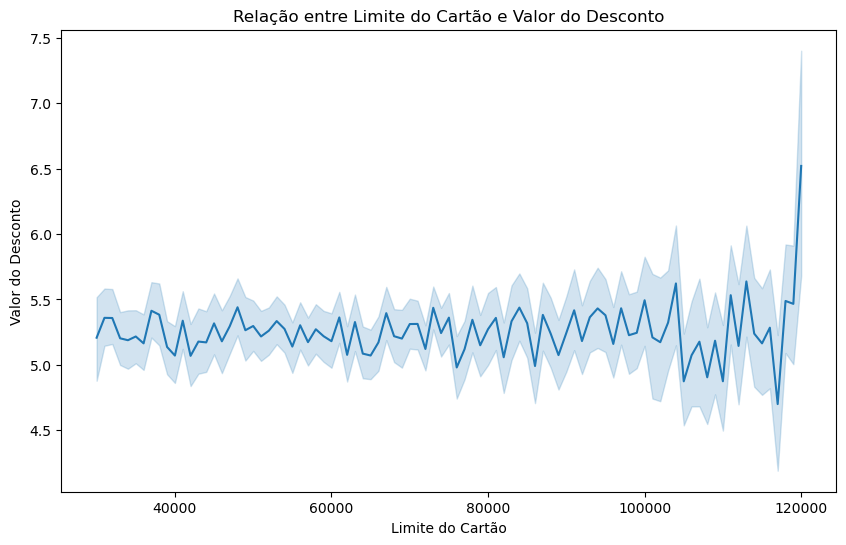

In [138]:
# Analisando o limite do cartão com o valor do desconto
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_unique_multiple_id_oferta, x='limite_cartao', y='valor_desconto')
plt.title('Relação entre Limite do Cartão e Valor do Desconto')
plt.xlabel('Limite do Cartão')
plt.ylabel('Valor do Desconto')
plt.show()

c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a

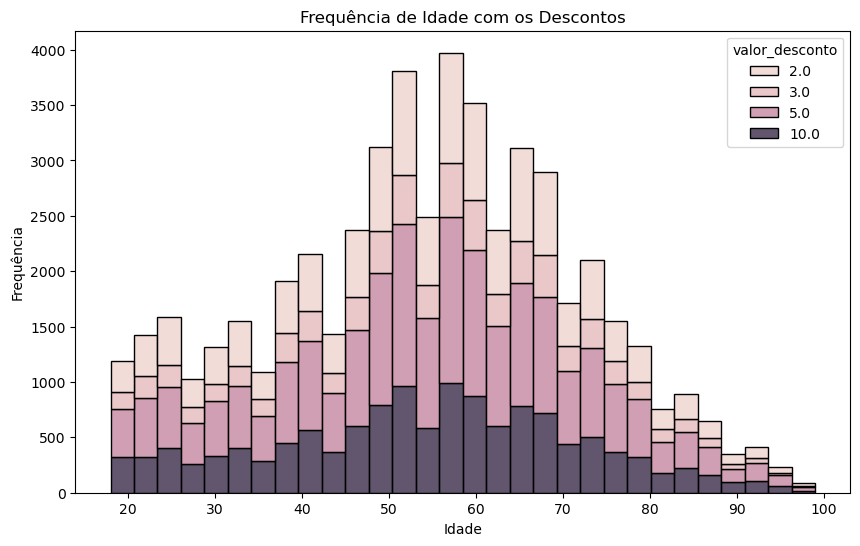

In [139]:
# Criar um histograma para analisar a frequência de idade com os descontos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_unique_multiple_id_oferta, x='idade', hue='valor_desconto', multiple='stack', bins=30)
plt.title('Frequência de Idade com os Descontos')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

In [140]:
# Analisando o o valor do desconto por canal de distruibuição 
colunas = ["'email'", "'mobile'", "'social'", "'web'"]
descricao_por_coluna = {}

# Agrupar por cada coluna e extrair as estatísticas descritivas de valor_desconto
for coluna in colunas:
    descricao_por_coluna[coluna] = df_unique_multiple_id_oferta.groupby(coluna)['valor_desconto'].describe()

for coluna, descricao in descricao_por_coluna.items():
    print(f"Descrição para a coluna {coluna}:")
    print(descricao)
    print("\n")

Descrição para a coluna 'email':
           count      mean       std  min  25%  50%  75%   max
'email'                                                       
yes      52423.0  5.250444  2.988427  2.0  3.0  5.0  5.0  10.0


Descrição para a coluna 'mobile':
            count      mean       std  min  25%  50%   75%   max
'mobile'                                                        
yes       45803.0  5.286641  3.195484  2.0  2.0  5.0  10.0  10.0


Descrição para a coluna 'social':
            count      mean       std  min  25%  50%   75%   max
'social'                                                        
yes       32691.0  6.000948  3.409096  2.0  3.0  5.0  10.0  10.0


Descrição para a coluna 'web':
         count      mean       std  min  25%  50%  75%   max
'web'                                                       
yes    45838.0  4.568131  2.550956  2.0  2.0  5.0  5.0  10.0




### Agora vamos analisar o perfil dos gastos dos clientes em cada transação

In [141]:
df_transacoes = df[df['evento'] == 'transaction']
# Analisando por genero
perfil_genero = df_transacoes.groupby('genero')['quantia'].describe()
perfil_genero

,count,mean,std,min,25%,50%,75%,max
genero,,,,,,,,
F,49262.0,17.488521,35.383233,0.05,7.95,15.00,22.11,1062.28
M,72770.0,11.603045,28.968101,0.05,2.57,7.05,16.22,977.78


c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


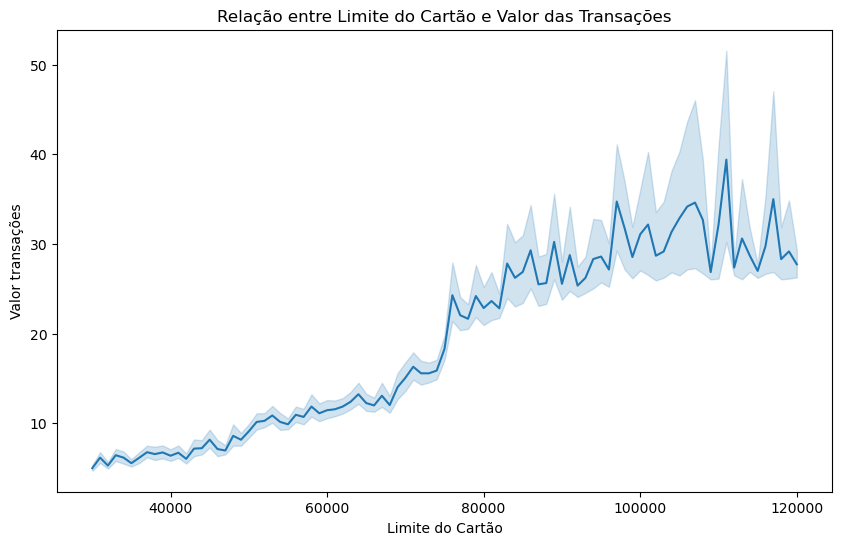

In [142]:
# Analisando o limite do cartão com o valor gasto em transações
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_transacoes, x='limite_cartao', y='quantia')
plt.title('Relação entre Limite do Cartão e Valor das Transações')
plt.xlabel('Limite do Cartão')
plt.ylabel('Valor transações')
plt.show()

C:\Users\sensix\AppData\Local\Temp\ipykernel_1124\552831585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transacoes['faixa_etaria'] = pd.cut(df_transacoes['idade'], bins=bins, labels=labels, right=False)
C:\Users\sensix\AppData\Local\Temp\ipykernel_1124\552831585.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_gastos = df_transacoes.groupby('faixa_etaria')['quantia'].mean()
C:\Users\sensix\AppData\Local\Temp\ipykernel_1124\552831585.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ve

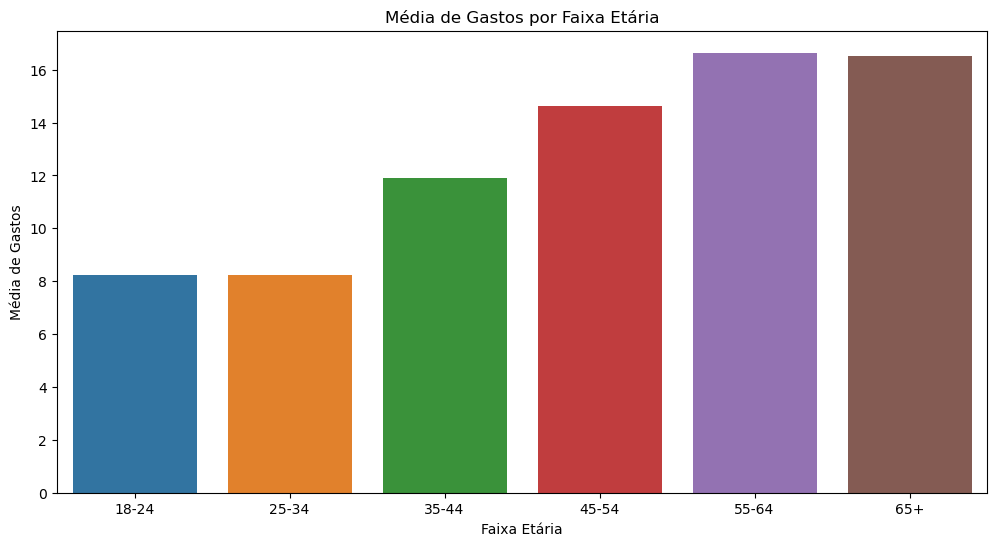

In [143]:
# Faixas etárias
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_transacoes['faixa_etaria'] = pd.cut(df_transacoes['idade'], bins=bins, labels=labels, right=False)

# Calcular a média e o valor acumulado por faixa etária
media_gastos = df_transacoes.groupby('faixa_etaria')['quantia'].mean()
acumulado_gastos = df_transacoes.groupby('faixa_etaria')['quantia'].sum()

# Visualizar a média de gastos por faixa etária
plt.figure(figsize=(12, 6))
sns.barplot(x=media_gastos.index, y=media_gastos.values)
plt.title('Média de Gastos por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Média de Gastos')
plt.show()

c:\Users\sensix\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


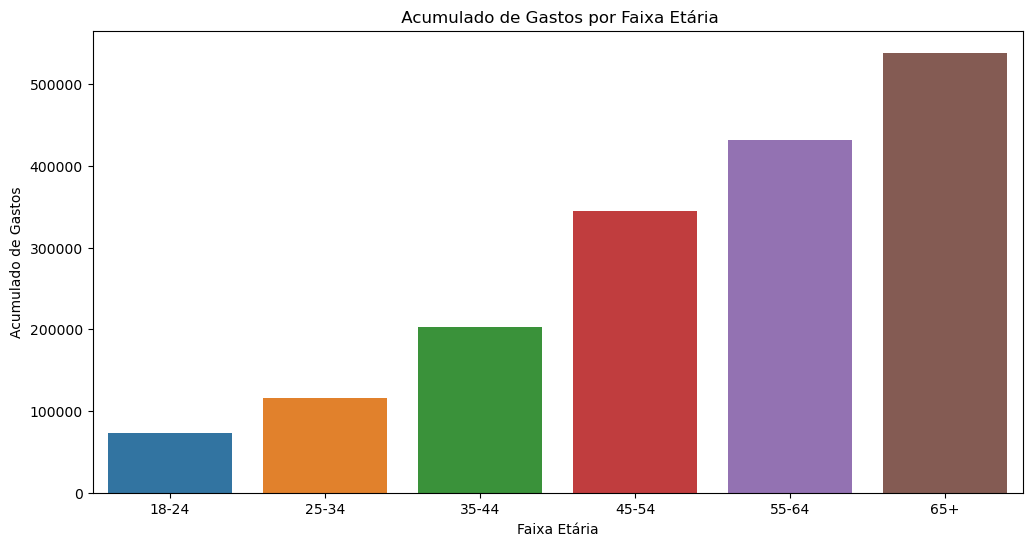

In [144]:
# Visualizar a média de gastos por faixa etária
plt.figure(figsize=(12, 6))
sns.barplot(x=acumulado_gastos.index, y=acumulado_gastos.values)
plt.title(' Acumulado de Gastos por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Acumulado de Gastos')
plt.show()

### Principais insights analisados:

#### Cupons

1º Analisando os valores de desconto por gênero: 

Percebemos que a média não muda muito, porém o volume de descontos utilizados do publico masculino é maior que o feminino.

2º O limite do cartão não tem influêncai no valor de desconto.

3º Analisando o histograma dos descontos, percebemos que o cupom com mais usado está na faixa estária de 40 a 60 anos com um valor de R$ 5,00.

4º A maioria dos cupons são aceitos nos canais de Web, Mobible e email.

#### Transações 

1º Analisando as transações por gênero:

O publico masculino tem mais transações porém o publico feminino tem um média maior de transações.

2º O limite do cartão está diretamente relacionado ao valor das transações.

3º O público mais jovem tende a gastar menos que os público mais velho.

## Treinamento do modelo 

In [145]:
# Precisamos preparar os dados para treinar o modelo
# Selecionar as colunas que serão usadas para treinar o modelo
df["offer_received"] = df["evento"].apply(lambda x: 1 if x == "offer received" else 0)
df = df.dropna(subset=['genero','valor_minimo_compra','valor_desconto'])
df['genero'] = df['genero'].map({'M': 0, 'F': 1})
x = df[['idade',
        'genero',
        'limite_cartao',
        'valor_minimo_compra',
        'valor_desconto']]

y = df['offer_received']

# Divida os dados em treino e teste (se ainda não tiver feito isso)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


C:\Users\sensix\AppData\Local\Temp\ipykernel_1124\3838651749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genero'] = df['genero'].map({'M': 0, 'F': 1})


In [146]:
# Treinar o modelo
model = GradientBoostingClassifier()
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Avaliar o modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14765
           1       0.57      1.00      0.73     19599

    accuracy                           0.57     34364
   macro avg       0.29      0.50      0.36     34364
weighted avg       0.33      0.57      0.41     34364

AUC: 0.5


c:\Users\sensix\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sensix\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sensix\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
# Probabilidades de aceitação do modelo (valores entre 0 e 1)
prob_acceptance = best_model.predict_proba(x)[:, 1]
print(f"Probabilidades de aceitação média da oferta: {np.mean(prob_acceptance)}")

# O valor médio de transação 
media_transacao = df_transacoes['quantia'].mean()
print(f"Valor médio de transação atual: R$ {media_transacao:.2f}")

# Valor total de transações
sum_transacoes = df_transacoes['quantia'].sum()
print(f"Total de transações atual: R$ {sum_transacoes:.2f}")

# A receita esperada por cliente com base na probabilidade de aceitação da oferta
expected_revenue_per_user = prob_acceptance * media_transacao

# Receita total esperada com base na probabilidade de aceitação da oferta
total_expected_revenue = np.sum(expected_revenue_per_user)
aumento_percentual_medio = total_expected_revenue / len(df)

# percentual de aumento
percentual_aumento_total = (total_expected_revenue / sum_transacoes) * 100

# Exiba os resultados
print(f"Receita Total Projetada com o modelo: R$ {total_expected_revenue:.2f}")
print(f"Aumento Percentual Médio por Cliente: R$ {aumento_percentual_medio:.2f}")
print(f"Aumento Percentual Total na receita: {percentual_aumento_total:.2f}%")

Probabilidades de aceitação média da oferta: 0.5726128980627699
Valor médio de transação atual: R$ 12.78
Total de transações atual: R$ 1775451.97
Receita Total Projetada com o modelo: R$ 838073.40
Aumento Percentual Médio por Cliente: R$ 7.32
Aumento Percentual Total na receita: 47.20%
